In [156]:
import numpy as np
import scipy as sp
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

We first define the complex pdf we draw samples from and attempt to reproduce via diffusion.

In [219]:
def complex_pdf(x):
    return (
        np.exp(-0.5 * ((x + 3) / 0.5) ** 2) +  
        0.8 * np.exp(-0.5 * ((x - 1) / 1) ** 2) +  
        0.4 * np.exp(-0.5 * ((x - 4) / 0.7) ** 2)  
    )

# For analytical plot
x_analytical = np.linspace(-7, 7, 1000)
pdf_values = complex_pdf(x_analytical)
pdf_values /= np.trapz(pdf_values, x_analytical) 

In [202]:
def sample_from_pdf(pdf, x_range, n_samples):
    '''
    Returns n samples from the given pdf using rejection sampling.
    ---
    NB. These will be the x_0s in the diffusion context.
    '''
    x_min, x_max = x_range
    samples = []
    max_pdf = np.max(pdf(x))
    
    while len(samples) < n_samples:
        x_rand = np.random.uniform(x_min, x_max)
        y_rand = np.random.uniform(0, max_pdf)
        if y_rand < pdf(x_rand):
            samples.append(x_rand)
    
    return np.array(samples)

We plot the analytical and experimental form of the pdf.

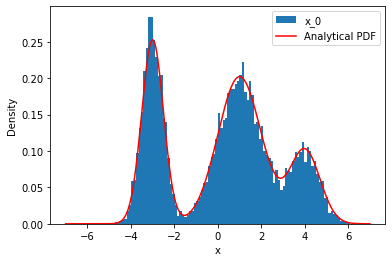

In [220]:
plt.hist(sample_from_pdf(complex_pdf, (-7, 7), 10000), bins=100, density=True, alpha=1, label='x_0')
plt.plot(x_analytical, pdf_values, label='Analytical PDF', c='r')
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

Now we define a function to generate training samples, x_t for various t. 

We use linear beta schedule and 100 time steps, final parameter forces all x_0 to reach x_T to check that the final distribution is gaussian.


In [182]:
def training_data(num_samples, T=100, check=0):
    '''
    Returns x_t, t, epsilon.
    '''
    x_0 = sample_from_pdf(complex_pdf, (-7, 7), num_samples).reshape(-1, 1) 

    if check:
        t = check * np.ones_like(x_0, dtype=int)
    else:
        t = np.random.randint(1, T-1, size=(num_samples, 1))

    beta_schedule = np.linspace(1e-4, 0.02, T)
    alpha_t = 1 - beta_schedule
    alpha_bar_t = np.cumprod(alpha_t)
    # print(t)
    # plt.plot(beta_schedule)
    # plt.plot(alpha_t)
    # plt.plot(alpha_bar_t)
    # plt.show()

    epsilon = np.random.normal(0, 1, size=(num_samples, 1))
    x_t = np.sqrt(alpha_bar_t)[t] * x_0 + np.sqrt(1 - alpha_bar_t)[t] * epsilon

    return x_0, x_t, t, epsilon

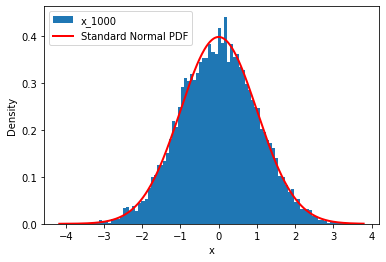

In [215]:
x_0, x_t, t, epsilon = training_data(10000, T=1000, check=999)

plt.hist(x_t, bins=100, density=True, alpha=1, label="x_1000")
x = np.linspace(min(x_t), max(x_t), 500)
normal_pdf = sp.stats.norm.pdf(x, loc=0, scale=1)
plt.plot(x, normal_pdf, 'r-', lw=2, label="Standard Normal PDF")

# Add labels, legend, and show the plot
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
# plt.title("Histogram with Standard Normal Curve")
plt.show()

The neural network attempts to predict the epsilon (noise) added in the forward process, as a function of x_t and t, so the neural network must also take t as an input. 

This is done by sinusoidal encoding, which expresses t as a high-dimensional vector, so the network can learn the influence of t better than just treating as a scalar.

Generated by ChatGPT.

In [111]:
def sinusoidal_encoding(t, dim):
    """
    Sinusoidal positional encoding for timestep t.
    Args:
        t: Timestep (scalar or tensor). Shape: (batch_size, 1).
        dim: Encoding dimension (even integer).
    Returns:
        Positional encoding tensor. Shape: (batch_size, dim).
    """
    # Ensure t is 2D: If t is 1D, add a dimension (e.g., shape becomes [batch_size, 1])
    t = t.unsqueeze(-1) if len(t.shape) == 1 else t  
    
    # Generate frequency scaling factors (logarithmically spaced across the dimension)
    freqs = torch.pow(10000, -torch.arange(0, dim, 2).float() / dim)
    
    # Compute sinusoidal encoding for each frequency
    encoding = torch.cat([torch.sin(t * freqs), torch.cos(t * freqs)], dim=-1)
    return encoding

Now we start building the neural network model which will attempt to predict the epsilon parameter used to in the forward process (in the training_data function).

In [112]:
class ReverseProcessNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, encoding_dim):
        super(ReverseProcessNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + encoding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
        self.encoding_dim = encoding_dim
    
    def forward(self, x_t, t):
        t_data_encoded = sinusoidal_encoding(t, dim=self.encoding_dim)
        input = torch.cat([x_t, t_data_encoded], dim=-1)
        return self.net(input)

In [117]:
model = ReverseProcessNN(input_dim=1, hidden_dim=128, encoding_dim=64)

optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

Now we define a function to train the data.

In [118]:
def train(model, data_loader, optimiser, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        for x_t, t, epsilon in data_loader:
            x_t, t, epsilon = x_t.float(), t.float(), epsilon.float()

            optimiser.zero_grad()

            epsilon_pred = model(x_t, t)
            loss = criterion(epsilon_pred, epsilon)

            loss.backward()
            optimiser.step()
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')


Now we generate training data and train the model!

In [120]:
_, x_t, t, epsilon = training_data(10000, T=1000)

data = torch.utils.data.TensorDataset(
    torch.tensor(x_t, dtype=torch.float32),
    torch.tensor(t, dtype=torch.float32),
    torch.tensor(epsilon, dtype=torch.float32)
)
data_loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)

train(model, data_loader, optimiser, criterion, epochs=2000)

Epoch 1/2000, Loss: 0.4957975745201111
Epoch 2/2000, Loss: 0.18196645379066467
Epoch 3/2000, Loss: 1.1740881204605103
Epoch 4/2000, Loss: 0.2214631289243698
Epoch 5/2000, Loss: 0.6699120402336121
Epoch 6/2000, Loss: 0.24068501591682434
Epoch 7/2000, Loss: 0.5874610543251038
Epoch 8/2000, Loss: 0.3687978982925415
Epoch 9/2000, Loss: 0.3370126485824585
Epoch 10/2000, Loss: 0.42018795013427734
Epoch 11/2000, Loss: 0.5439724922180176
Epoch 12/2000, Loss: 0.3746814429759979
Epoch 13/2000, Loss: 0.5676860213279724
Epoch 14/2000, Loss: 0.3047233819961548
Epoch 15/2000, Loss: 0.24213749170303345
Epoch 16/2000, Loss: 0.22012634575366974
Epoch 17/2000, Loss: 0.37044358253479004
Epoch 18/2000, Loss: 0.40425199270248413
Epoch 19/2000, Loss: 0.2552390694618225
Epoch 20/2000, Loss: 0.2647947371006012
Epoch 21/2000, Loss: 0.17891082167625427
Epoch 22/2000, Loss: 0.2739661633968353
Epoch 23/2000, Loss: 0.3925727605819702
Epoch 24/2000, Loss: 0.4054929316043854
Epoch 25/2000, Loss: 0.3638276755809784
E

In [138]:
def reverse_process(model, num_samples, T=1000, until=0):
    model.eval()

    beta_schedule = np.linspace(1e-4, 0.02, T)
    alpha_t = 1 - beta_schedule
    alpha_bar_t = np.cumprod(alpha_t)

    x_t = torch.randn((num_samples, 1))

    for t in range(T-1, until, -1):
        t_tensor = torch.full((num_samples, 1), t, dtype=torch.float32)

        epsilon_theta = model(x_t, t_tensor)

        beta_t = beta_schedule[t]
        alpha_t_torch = alpha_t[t]
        alpha_bar_t_torch = alpha_bar_t[t]

        x_prev = (1 / np.sqrt(alpha_t_torch)) * (
            x_t - (beta_t / np.sqrt(1 - alpha_bar_t_torch)) * epsilon_theta
            )
        
        if t > 1:
            z = torch.randn_like(x_t)
            x_prev += np.sqrt(beta_t) * z
        
        x_t = x_prev
    
    return x_t

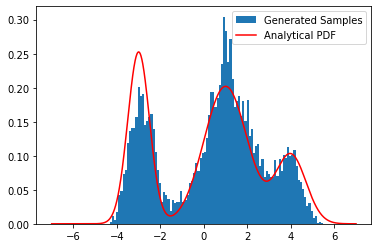

In [222]:
generated_samples = reverse_process(model, 10000, T=1000, until=0).detach().numpy()

plt.hist(generated_samples, bins=100, density=True, label='Generated Samples')
# plt.hist(sample_from_pdf(complex_pdf, (-7, 7), 10000), bins=100, density=True, alpha=0.5, label='Sampled PDF')
plt.plot(x_analytical, pdf_values, label='Analytical PDF', c='r')

plt.legend()
plt.show()